In [1]:
from functools import partial
from pathlib import Path
from turtle import color
from setuptools_scm import meta
import torch
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import tqdm as tqdm

from sbi.inference import simulate_for_sbi

import sys
sys.path.append('../../valDiags_flows/')
sys.path.remove('/data/parietal/store/work/jlinhart/git_repos/HNPE')

from hnpe.misc import make_label
from hnpe.posterior import build_flow, IdentityJRNMM, get_posterior
from hnpe.simulator import prior_JRNMM, simulator_JRNMM, get_ground_truth
from hnpe.summary import summary_JRNMM
from hnpe.plot import plot_pairgrid_with_groundtruth

from diagnostics.pp_plots import multi_cde_pit_values, PP_plot_1D, sbc_plot, confidence_region_null, multi_pp_plots
from diagnostics.multi_local_test import multivariate_lct, get_lct_results, compute_test_statistic
from diagnostics.hpd_coverage import highest_density_level, highest_density
from diagnostics.localPIT_regression import localPIT_regression_baseline, local_correlation_regression
from data.feature_transforms import identity


## SBI Task: Inference of the JR-NMM parameters under uniform prior
We fix the gain parameter at $g=0$ to simplify the task: no indeterminacy (coupling between $g, \mu, \sigma$), 3D instead of 4D parameter space (can be visualized more easily).

- Prior: `torch.Size([1, 4])`
    $$p(\theta) = \mathcal{U}([10,250], [50,500], [100,5000])$$
- Simualtor (JR-NMM): `torch.Size([1, 1024])`
    $$x \sim \text{Simulator}(\theta) \approx p(x\mid \theta) \text{, where } \theta = (C, \mu, \sigma)$$ 
- Summary Statistics (Fourier log Power Spectral Density): `torch.Size([1, 33])`
    $$s(x) = \text{log-PSD}(x)$$

**Goal:** estimate $p(\theta\mid x_0)$ with a Normalizing Flow $q_{\phi}(\theta \mid s(x_0))$ with $x_0$ an observation genreated from ground-truth parameters $\theta_0 = (C_0, \mu_0, \sigma_0)$.

### Experimental SETUP

#### Global Variables

In [2]:

# PATH
PATH_EXPERIMENT = '../saved_experiments/JR-NMM/fixed_gain_3d/'

# DATASETS
B = 50_000 # train flow
B_PRIME = 10_000 # cal set / trianing classifiers for validation diagnostics
B_DOUBLE_PRIME = 1_000 # evaluate 
N_SAMPLES_POSTERIOR = 10_000

# DATA FEATURES
N_EXTRA = 0 # always as gain is fixed
SINGLE_REC = False

# MODEL FEATURES
NAIVE = True  # always as gain is fixed and n_extra =0

#### Meta-parameters

In [3]:
meta_parameters = {}
# Data features
meta_parameters['t_recording'] = 8
meta_parameters['n_extra'] = N_EXTRA
# Summary Features
meta_parameters["summary"] = "Fourier"
meta_parameters["n_sf"] = 33
# Training Features
meta_parameters["n_rd"] = 1  # amortized flow
meta_parameters["n_sr"] = B  # simulations per round

# example cases we are considering here
meta_parameters["case"] = PATH_EXPERIMENT+"Flows_amortized/JRNMM_nextra_{:02}_" \
                "naive_{}_" \
                "single_rec_{}".format(N_EXTRA,
                                    NAIVE,
                                    SINGLE_REC)

# label for saving directory of experiments
meta_parameters["label"] = make_label(meta_parameters)
folderpath = Path.cwd() / meta_parameters["label"]


#### Prior, Simulator and Summary Statistics

In [4]:
# Prior
prior = prior_JRNMM(parameters=[('C', 10.0, 250.0),
                                ('mu', 50.0, 500.0),
                                ('sigma', 100.0, 5000.0)])

# Simulator
simulator = partial(simulator_JRNMM,
                    input_parameters=['C', 'mu', 'sigma'],
                    t_recording=8,
                    n_extra=0,
                    p_gain=prior,
                    single_recording=False,)
                    # fixed_gain=True)  

# Summary features
summary_extractor = summary_JRNMM(n_extra=N_EXTRA,
                            d_embedding=meta_parameters['n_sf'],
                            n_time_samples=int(128*meta_parameters['t_recording']),
                            type_embedding=meta_parameters['summary'])
summary_extractor.embedding.net.logscale = True  # log-PSD         

### Load trained Estimator
In what follows, the estimator will try to approximate the posterior $p(\theta \mid x_0)$ with samples from the joint $(x_i, \theta_i) \sim p(x\mid \theta_i)p(\theta_i)$. 
the estimator actually trains on the summary statisctics of the time series $x_i = \text{Summary}(\text{Simulator}(\theta_i))$. 

In [5]:
filename = PATH_EXPERIMENT+f'posteriors_amortized/posterior_nextra_{N_EXTRA}_single_rec_{SINGLE_REC}_no_standardize_nsim_{B}.pkl'
if os.path.exists(filename):
        posterior = torch.load(filename)
else: 
    # choose a function which creates a neural network density estimator
    build_nn_posterior = partial(build_flow, 
                                embedding_net=IdentityJRNMM(),
                                naive=NAIVE,
                                aggregate=True,
                                z_score_theta=False,
                                z_score_x=False,
                                n_layers=10)  

    # get posterior 
    posterior = get_posterior(
        simulator, prior, summary_extractor, build_nn_posterior,
        meta_parameters, round_=0, path=PATH_EXPERIMENT+'Flows_amortized/JRNMM_nextra_00_trec_8naive_True_single_rec_False_no_standardize/Fourier_n_rd_1_n_sr_50000_n_sf_33/'
    )
    torch.save(posterior, filename)

# Validation

### Dataset generation

In [6]:
# Simulate Data, create datasets
filename = PATH_EXPERIMENT + f"datasets_small.pkl"

if os.path.exists(filename):
    datasets = torch.load(filename)
else:
    # # b_theta, b_x = data_gen.get_joint_data(B)
    # b_prime_theta, b_prime_x = simulate_for_sbi(
    #     simulator=simulator, proposal=prior, num_simulations=B_PRIME
    # )
    # b_prime_x = summary_extractor(b_prime_x)
    b_double_prime_theta, b_double_prime_x = simulate_for_sbi(
        simulator=simulator, proposal=prior, num_simulations=B_DOUBLE_PRIME
    )
    b_double_prime_x = summary_extractor(b_double_prime_x)

    datasets = {
        # "B": {"theta": b_theta, "x": b_x},
        # "B_prime": {"theta": b_prime_theta, "x": b_prime_x},
        "B_double_prime": {"theta": b_double_prime_theta, "x": b_double_prime_x},
    }
    torch.save(datasets, filename)

datasets["B_prime"]["theta"].shape, datasets["B_prime"]["x"].shape, 
# datasets["B_double_prime"]["theta"].shape, datasets["B_double_prime"]["x"].shape

(torch.Size([10000, 3]), torch.Size([10000, 33, 1]))

In [7]:
x_cal, theta_cal = datasets['B_prime']['x'], datasets['B_prime']['theta'] # 10_000
x_cal.shape, theta_cal.shape


(torch.Size([10000, 33, 1]), torch.Size([10000, 3]))

In [8]:
param_names = [r'$\theta_1 = C$', r'$\theta_2 = \mu$', r'$\theta_3 = \sigma$']
colors=['orange', 'red', 'purple', 'blue']

## Global COVERAGE for multivariate density NPEs

### 1. PP-plots (marginal uniformity): Global PIT vs. SBC vs. HPD

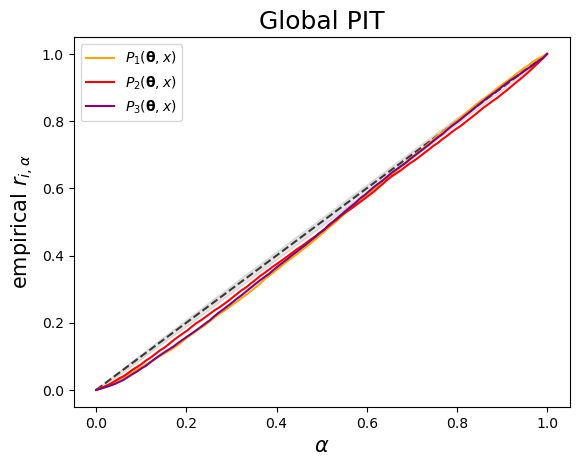

In [9]:
# PLOT EXPECTED PIT-DISTRIBUTION of the trained estimators

# Compute PIT-values of the flows 
# [PIT(Theta_i, X_i, maf_good) = F_{Q_good|X_i}(Theta_i)
flow_joint_pit_values = multi_cde_pit_values(
    theta_cal, x_cal, posterior, feature_transform=identity
)
flow_joint_pit_values = [flow_joint_pit_values[i] for i in range(3)]

# flow_joint_pit_values_permuted = apply_inv_permutations(flow_joint_pit_values)

# PP-plot of expected PIT-distribution 
# r_alpha = [P_X,Theta(Z < alpha)]
PP_plot_1D(
    PIT_values=flow_joint_pit_values,
    alphas=np.linspace(0, 1, 100),
    colors=colors,
    labels=[r'$P_1(\mathbf{\theta},x)$', r'$P_2(\mathbf{\theta},x)$', r'$P_3(\mathbf{\theta},x)$', r'$P_4(\mathbf{\theta},x)$'],
    title="Global PIT",
    ylabel=r"empirical $r_{i,\alpha}$",
    confidence_int = True,
    conf_alpha=0.05/4, # bonferonni correction: global level at 0.05
)

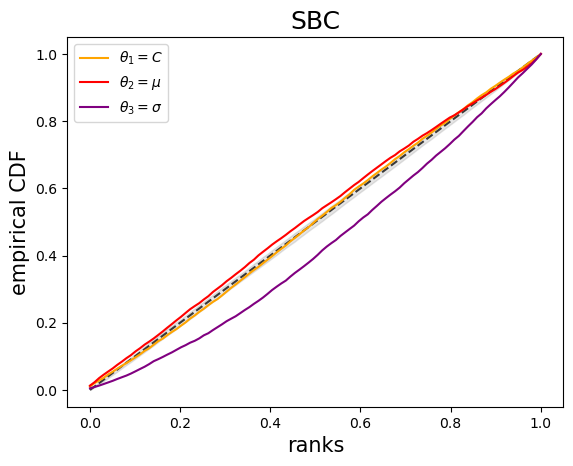

In [10]:
from sbi.analysis.sbc import run_sbc
from sbi.inference.posteriors.direct_posterior import DirectPosterior

if not os.path.exists(PATH_EXPERIMENT+'global_tests/sbc_no_standardize.pkl'):
    posterior_sbc = DirectPosterior(posterior_estimator=posterior, prior=prior,
            x_shape=datasets['B_prime']['x'][0][None, :].shape)

    sbc = run_sbc(datasets['B_prime']['theta'], datasets['B_prime']['x'][:,None,:,:], posterior=posterior_sbc)
    torch.save(sbc, PATH_EXPERIMENT+'global_tests/sbc_prime.pkl')
else:
    sbc_ranks = np.array(torch.load(PATH_EXPERIMENT+'global_tests/sbc_no_standardize.pkl')[0])

colors=colors
labels = param_names
sbc_plot(sbc_ranks, colors=colors, labels=labels, conf_alpha=0.05/4) # bonferonni correction: global level at 0.05*4 = 0.2

10002


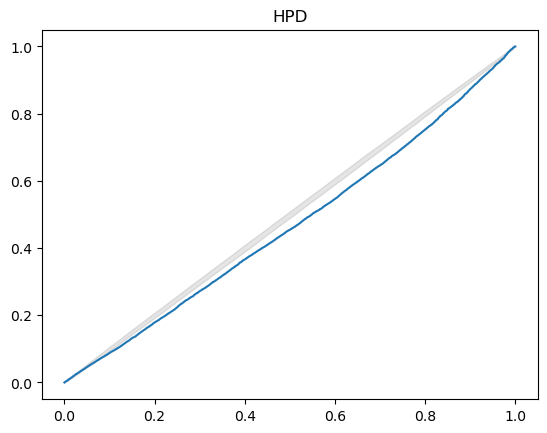

In [12]:
if os.path.exists(PATH_EXPERIMENT+'global_tests/hpd_ranks_no_standardize.pkl'):
    hpd_values = torch.load(PATH_EXPERIMENT+'global_tests/hpd_ranks_no_standardize.pkl')
    print(len(hpd_values))
else:
    hpd_values, alphas = highest_density(posterior, theta_cal, x_cal)
    torch.save(hpd_values, PATH_EXPERIMENT+'global_tests/hpd_ranks_no_standardize.pkl')

alphas_hpd = np.linspace(0.0, 1.0, len(hpd_values))
alphas = np.linspace(0, 1, 100)
confidence_region_null(alphas, N=B_PRIME, conf_alpha=0.05) # bonferonni correction

plt.plot(alphas_hpd, hpd_values)
plt.title("HPD")
plt.show()


### 2. Global C2ST

In [26]:
from sbi.utils.metrics import c2st_scores
import torch.distributions as D

flow_values_cal = posterior._transform(theta_cal, context=x_cal)[0].detach()
norm_samples = D.MultivariateNormal(torch.zeros(3), torch.eye(3)).sample((len(x_cal),))
scores = c2st_scores(flow_values_cal, norm_samples, n_folds=10)
print('flow:', np.mean(scores).__round__(2), '+/-', np.std(scores).__round__(2))

flow: 0.53 +/- 0.01


## LOCAL COVERAGE

### Ground-truth parameters and observations for evaluation

In [13]:
# ground-truth parameters to generate observation

load_existing = True

if not load_existing:
    # fixed_params
    c = 300.0
    mu = 220.0 
    sigma = 2000.0
    theta_true_ood = torch.FloatTensor([c, mu, sigma])

    theta_true_list = prior.sample((5,))
    x_obs_list = []
    for theta in theta_true_list:
        meta_parameters['theta'] = theta

        ground_truth = get_ground_truth(meta_parameters,
                                    input_parameters=['C', 'mu', 'sigma'],
                                    p_gain=prior, single_recording=SINGLE_REC)
        ground_truth['observation'] = summary_extractor(ground_truth['observation'])
        x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])
        x_obs_list.append(x_obs)

    meta_parameters['theta'] = theta_true_ood

    ground_truth = get_ground_truth(meta_parameters,
                                input_parameters=['C', 'mu', 'sigma'],
                                p_gain=prior, single_recording=SINGLE_REC)
    ground_truth['observation'] = summary_extractor(ground_truth['observation'])
    x_obs = ground_truth['observation'] # torch.Size([1, 33, n_extra+1])

    x_obs_list.append(x_obs)
    theta_true_list = torch.cat([theta_true_list, theta_true_ood[None,:]], dim=0)
    x_obs_list = torch.stack(x_obs_list)[:,0,:,:]

    torch.save([theta_true_list, x_obs_list], PATH_EXPERIMENT+'gt_observations.pkl')
else:
    theta_true_list = torch.load(PATH_EXPERIMENT+'gt_observations.pkl')[0]
    x_obs_list = torch.load(PATH_EXPERIMENT+'gt_observations.pkl')[1]
    print(x_obs_list.shape, theta_true_list.shape)

torch.Size([6, 33, 1]) torch.Size([6, 3])


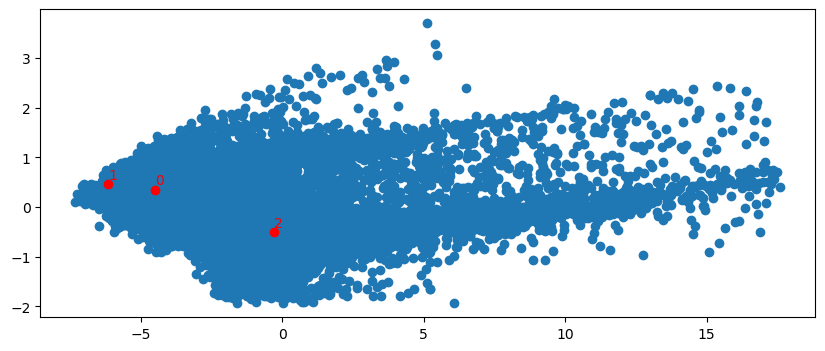

In [83]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cal[:,:,0]) 
x_new = pca.transform(x_cal[:,:,0])

plt.scatter(x_new[:,0],x_new[:,1])
x_new_obs = pca.transform(x_obs_list[:3,:,0])
plt.scatter(x_new_obs[:,0],x_new_obs[:,1], color='red')
for i in range(len(x_obs_list[:3])):
    plt.text(x_new_obs[i,0],x_new_obs[i,1]+0.1, str(i), color='red')
plt.show()

### Estimated Posteriors

/data/parietal/store/work/jlinhart/miniconda3/envs/sdbm/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


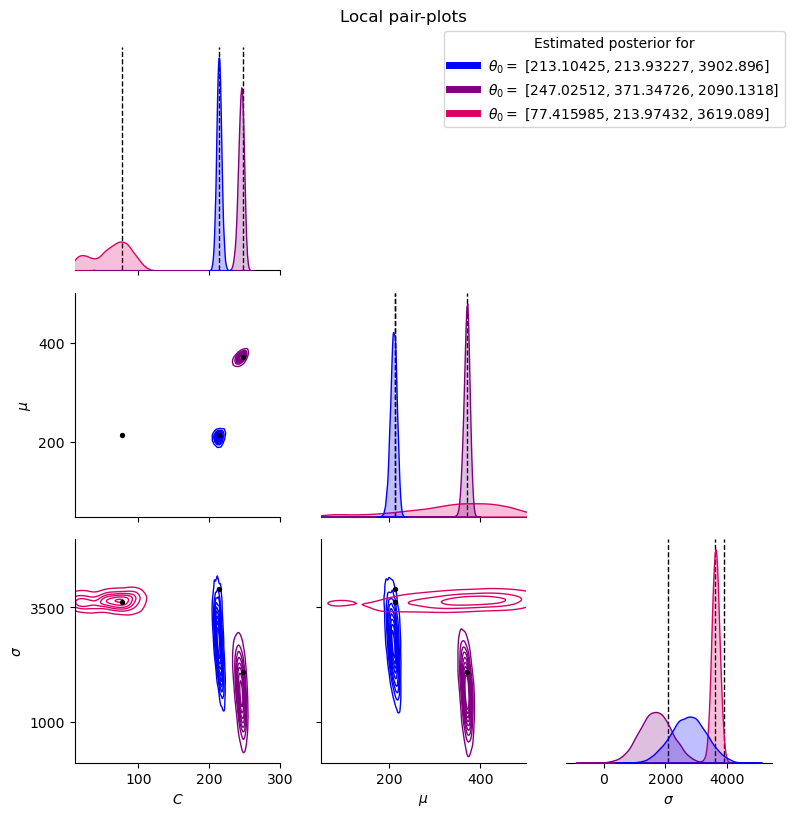

In [15]:
from plot import plot_pairgrid_with_groundtruth

# Plot learned posteriors with true parameters 

posteriors = {}
context = {}
for i,x_obs in enumerate(x_obs_list[:3]):
    # filename_posterior = PATH_EXPERIMENT+f"posteriors_amortized/naive_posterior_nextra_{exp['n_extra']}_single_rec_{exp['single_rec']}_nsim_{exp['n_sim']}.pkl"
    # filename_xobs = PATH_EXPERIMENT+f"gt_observations/nextra_{exp['n_extra']}/gt_observation_gain_{exp['gt_gain']}_new.pkl"
    
    label = r"$\theta_0 =$"+f" {list(theta_true_list[i].numpy())}"
    posteriors[label]= posterior #torch.load(filename_posterior)
    # context[label] = torch.load(filename_xobs)
    context[label] = x_obs[None,:,:]

# color_dict = dict(zip(list(posteriors.keys()), ['#32327B', '#3838E2', '#52A9F5']))
color_dict = dict(zip(list(posteriors.keys()), ['blue','purple', '#D90368', '#FFA500','gold']))

g = plot_pairgrid_with_groundtruth(
    posteriors=posteriors,
    context = context,
    theta_gt=theta_true_list[:3],
    color_dict=color_dict,
    handles=[
        plt.Line2D([], [], color=color_dict[label], linewidth=5, label=label) for label in list(posteriors.keys())
    ],
    n_samples=N_SAMPLES_POSTERIOR,
    title = r'Estimated posterior for',
    fixed_gain=True
)
plt.show()

### Local C2ST 


In [16]:
clfs = torch.load('../saved_experiments/JR-NMM/fixed_gain_3d/lc2st_results/12500/clfs_jrnmm_no_standardize_n_trials_1000.pkl')
clfs_null = torch.load('../saved_experiments/JR-NMM/fixed_gain_3d/lc2st_results/12500/clfs_null_n_trials_1000.pkl')

In [17]:
from scipy.stats import multivariate_normal as mvn
from diagnostics.localC2ST import eval_local_flow_c2st
n_trials = 1000
z_values = mvn(mean=np.zeros(3), cov=np.eye(3)).rvs(10000)

probas = {}
probas_null = {}
for i,x_obs in enumerate(x_obs_list[:3,:,0]):
    probas[i] = []
    probas_null[i] = []
    for t in range(n_trials):
        proba, _ = eval_local_flow_c2st(clfs[t], x_obs, dim=3, size=10000, z_values=z_values)
        proba_null, _ = eval_local_flow_c2st(clfs_null[t], x_obs, dim=3, size=10000, z_values=z_values)
        probas[i].append(proba)
        probas_null[i].append(proba_null)

#### Histograms


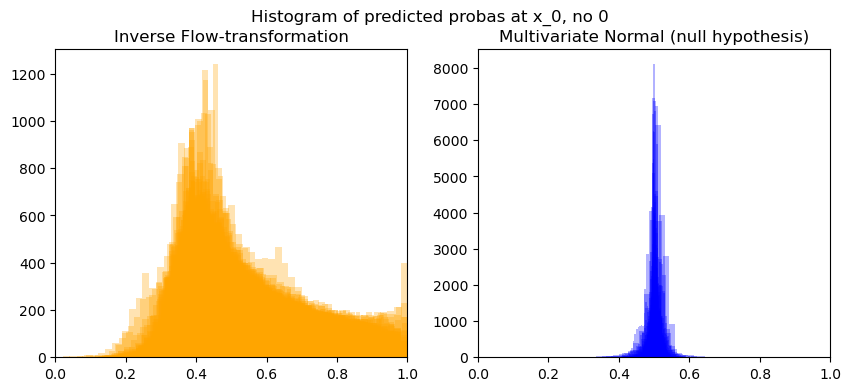

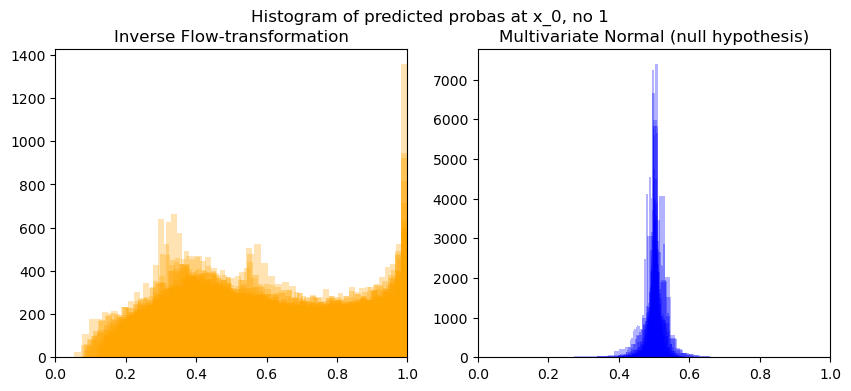

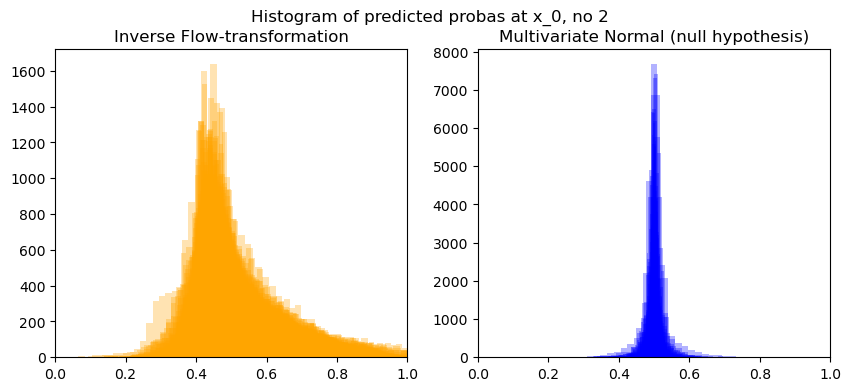

In [81]:
# Plot histograms
n_trials = 100

plt.rcParams["figure.figsize"] = (10, 4)
for i in range(len(x_obs_list[:3])):
    fig, axs = plt.subplots(1,2)
    for t in range(n_trials):
        axs[0].hist(probas[i][t], alpha=0.3, bins=50, color='orange')
        axs[1].hist(probas_null[i][t], alpha=0.3, bins=50, color='blue')
    axs[0].set_title('Inverse Flow-transformation')
    axs[1].set_title('Multivariate Normal (null hypothesis)')
    axs[0].set_xlim(0,1)
    axs[1].set_xlim(0,1)
    plt.suptitle(f'Histogram of predicted probas at x_0, no {i}')
    plt.show()

#### Tests Statistics

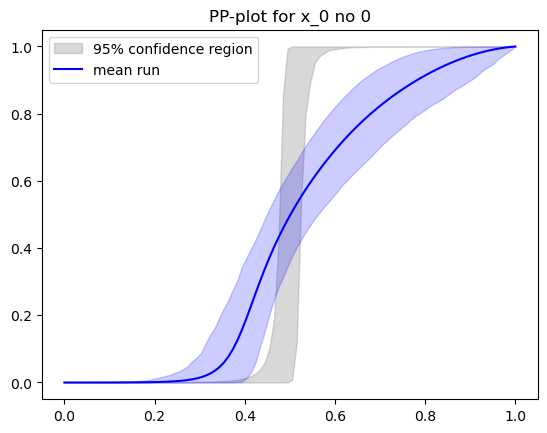

NB samples = 12500
std 0.011078889642365515
test stat:  0.03753148749421106 w_dist:  0.12551733810206298
p-value:  0.015 p_value_w:  0.0
rejected
rejected (w_dist)


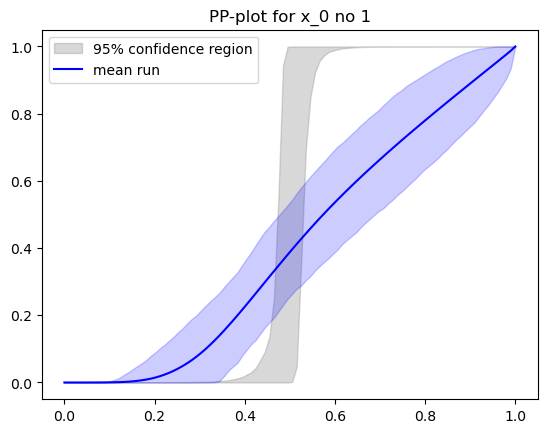

NB samples = 12500
std 0.011504887918155847
test stat:  0.06762063657861261 w_dist:  0.1938650373208388
p-value:  0.003 p_value_w:  0.0
rejected
rejected (w_dist)


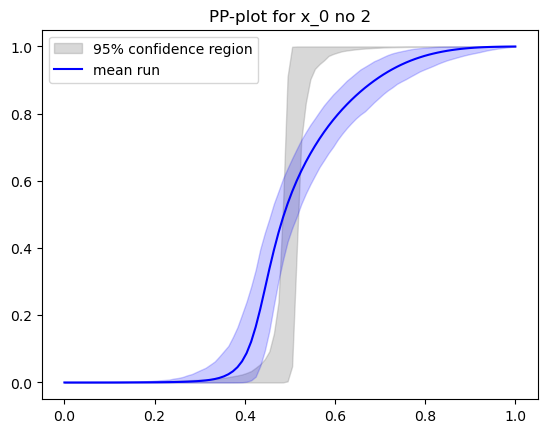

NB samples = 12500
std 0.0153873582303086
test stat:  0.02461617623303269 w_dist:  0.08659029035017295
p-value:  0.013 p_value_w:  0.0
rejected
rejected (w_dist)


In [84]:
# Plot PP-plots and compute test-statistics/p-values
from diagnostics.pp_plots import PP_vals
from scipy.stats import wasserstein_distance

plt.rcParams.update(plt.rcParamsDefault)

test_stat = {}
w_dist_mean = {}
p_value = {}
p_value_w = {}
reject = {}
reject_w = {}

for i in range(3):

    alphas = np.linspace(0,1,100)
    pp_vals_dirac = PP_vals([0.5]*10000, alphas)

    # nb samples = 10000
    # plt.plot(alphas, pp_vals_dirac, '--', color='black')

    pp_vals_null = {}
    test_stats_null = {}
    w_dist_null = []
    for t in range(len(probas_null[0])):
        pp_vals_null[t] = pd.Series(PP_vals(probas_null[i][t], alphas))
        test_stats_null[t] = ((pp_vals_null[t]- pp_vals_dirac) ** 2).sum() / len(alphas)
        w_dist_null.append(wasserstein_distance([0.5]*10000, probas_null[i][t]))
    
    pp_vals = {}
    w_dist = []
    for t in range(1000):
        pp_vals[t] = pd.Series(PP_vals(probas[i][t], alphas))
        w_dist.append(wasserstein_distance([0.5]*1000, probas[i][t]))

    low_null = pd.DataFrame(pp_vals_null).quantile(0.05/2, axis=1)
    up_null = pd.DataFrame(pp_vals_null).quantile(1-0.05/2, axis=1)
    plt.fill_between(alphas, low_null, up_null, label='95% confidence region', color="grey", alpha=0.3)

    low = pd.DataFrame(pp_vals).quantile(0.05/2, axis=1)
    up = pd.DataFrame(pp_vals).quantile(1-0.05/2, axis=1)
    line = pd.DataFrame(pp_vals).mean(axis=1)
    plt.plot(alphas, line, label='mean run', color='blue')
    plt.fill_between(alphas, low, up, color="blue", alpha=0.2)
    plt.legend()
    plt.title(f'PP-plot for x_0 no {i}')
    plt.show()


    test_stat[i] = ((line - pp_vals_dirac) ** 2).sum() / len(alphas)
    p_value[i] = sum(1 * (test_stat[i] < pd.Series(test_stats_null))) / len(test_stats_null)

    w_dist_mean[i] = np.mean(w_dist)
    p_value_w[i] = sum(1 * (w_dist_mean[i] < pd.Series(w_dist_null))) / len(w_dist_null)
    
    print('NB samples = 12500')
    print('std', pd.DataFrame(probas_null[i]).std(axis=1).mean())
    print('test stat: ', test_stat[i], 'w_dist: ', w_dist_mean[i])
    print('p-value: ', p_value[i], 'p_value_w: ', p_value_w[i])
    if p_value[i] <= 0.05:
        print('rejected')
        reject[i] = True
    else:
        print('not rejected')
        reject[i] = False
    
    if p_value_w[i] <= 0.05:
        print('rejected (w_dist)')
        reject_w[i] = True
    else:
        print('not rejected (w_dist)')
        reject_w[i] = False

In [85]:
# Show test results in dataframe
df_results = {}
df_results['TV_dist'] = pd.DataFrame({
    'test_stat': test_stat, 
    'p_value': p_value, 
    'rejected': reject 
})
df_results['w_dist'] = pd.DataFrame({
    'test_stat': w_dist_mean, 
    'p_value': p_value_w, 
    'rejected': reject_w 
})
pd.concat({k: pd.DataFrame(v).T for k, v in df_results.items()}, axis=0)

0         1         2
TV_dist test_stat  0.037531  0.067621  0.024616
        p_value       0.015     0.003     0.013
        rejected       True      True      True
w_dist  test_stat  0.125517  0.193865   0.08659
        p_value         0.0       0.0       0.0
        rejected       True      True      True

#### Interpretability number 0 

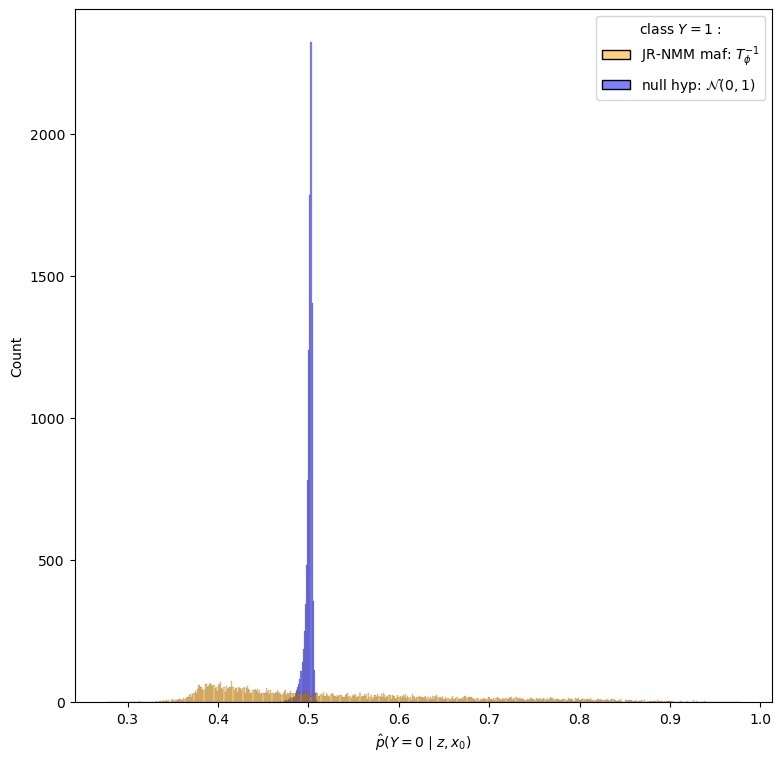

In [18]:
# plot predicted probas for x_0 no 0
probas_z = np.concatenate(
    [
        np.mean(probas[0], axis=0),
        np.mean(probas_null[0], axis=0),
    ]
)
# grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'JR-NMM maf: $T^{-1}_{\phi}$']*10000+[r'null hyp: $\mathcal{N}(0,1)$']*10000

df = pd.DataFrame({r'class $Y=1$ :': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas_z})

import seaborn as sns
sns.histplot(
        data=df, x=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'class $Y=1$ :',  palette=['orange', 'blue']
    )
plt.show()

In [65]:
df = pd.DataFrame({'z_1':z_values[:,0],'z_2':z_values[:,1], 'z_3':z_values[:,2], 'probas': np.array(probas[0]).mean(axis=0)})
# df[df['probas']>0.55]
df['intensity'] = ['uncertain']*len(df)
df.loc[df['probas']>0.55, 'intensity'] = 'high'
df.loc[df['probas']<0.45, 'intensity'] = 'low'

In [58]:
import plotly.express as px

fig = px.scatter_3d(df, x='z_1', y='z_2', z='z_3',
              color='intensity')
fig.show()

In [72]:
high_probas = z_values[np.where(df['intensity'] == 'high')[0]]
low_probas = z_values[np.where(df['intensity'] == 'low')[0]]
uncertain = z_values[np.where(df['intensity'] == 'uncertain')[0]]

fwd_flow = posterior._flow._transform.inverse(torch.FloatTensor(z_values), context=x_obs_list[0][None,:,0])[0].detach().numpy()
fwd_flow_hp = posterior._flow._transform.inverse(torch.FloatTensor(high_probas), context=x_obs_list[0][None,:,0])[0].detach().numpy()
fwd_flow_lp = posterior._flow._transform.inverse(torch.FloatTensor(low_probas), context=x_obs_list[0][None,:,0])[0].detach().numpy()
fwd_flow_u = posterior._flow._transform.inverse(torch.FloatTensor(uncertain), context=x_obs_list[0][None,:,0])[0].detach().numpy()

df['C'] = fwd_flow[:,0]
df['mu'] = fwd_flow[:,1]
df['sigma'] = fwd_flow[:,2]

fig = px.scatter_3d(df, x='C', y='mu', z='sigma',
              color='intensity')
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[10,250],),
                     yaxis = dict(nticks=4, range=[50,500],),
                     zaxis = dict(nticks=4, range=[100,5000],),),)
fig.show()

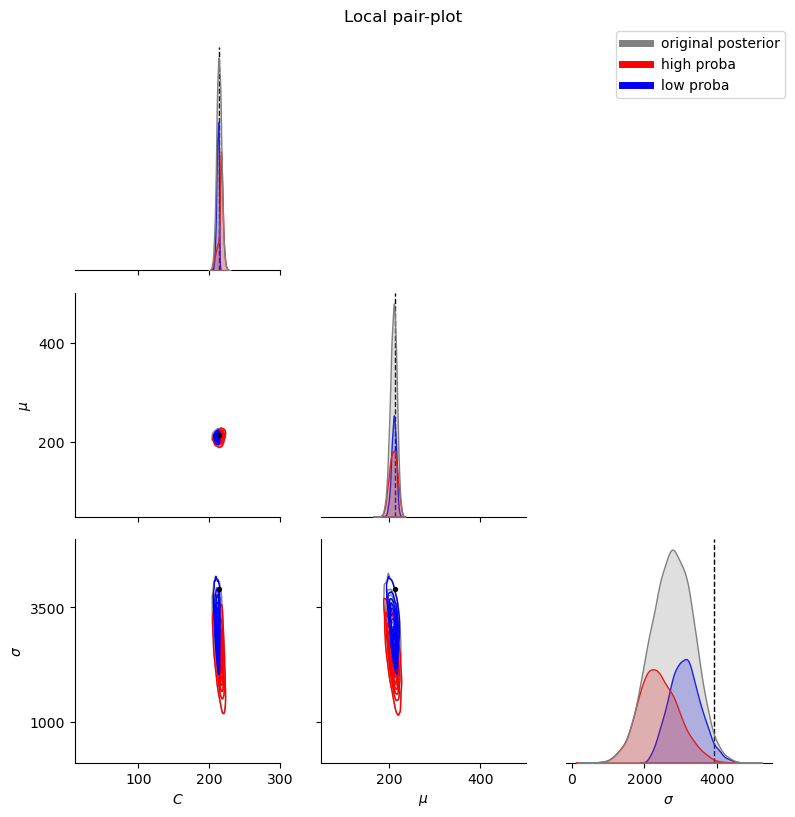

In [62]:
plt.rcParams["figure.figsize"] = (9, 9)

sample_list = [fwd_flow, fwd_flow_hp, fwd_flow_lp]
modes = ["original posterior","high proba","low proba"]
color_dict = dict(zip(modes, ['grey','red', 'blue']))
gt = theta_true_list[0]

dfs = []
for samples, mode in zip(sample_list,modes):
    df = pd.DataFrame(
        samples, columns=[r"$C$", r"$\mu$", r"$\sigma$"]
    )
    df["mode"] = mode
    dfs.append(df)

joint_df = pd.concat(dfs, ignore_index=True)

g = sns.PairGrid(
    joint_df, hue="mode", palette=color_dict, diag_sharey=False, corner=True
)
g.fig.set_size_inches(8, 8)

g.map_lower(sns.kdeplot, linewidths=1)
g.map_diag(sns.kdeplot, shade=True, linewidths=1)

g.axes[1][0].set_xlim(10.0, 300.0)  # C
g.axes[1][0].set_ylim(50.0, 500.0)  # mu
g.axes[1][0].set_yticks([200, 400])

g.axes[2][0].set_xlim(10.0, 300.0)  # C
g.axes[2][0].set_ylim(100.0, 5000.0)  # sigma
g.axes[2][0].set_yticks([1000, 3500])

g.axes[2][1].set_xlim(50.0, 500.0)  # mu
g.axes[2][1].set_ylim(100.0, 5000.0)  # sigma



C, mu, sigma = gt
# plot points
g.axes[1][0].scatter(C, mu, color="black", zorder=2, s=8)
g.axes[2][0].scatter(C, sigma, color="black", zorder=2, s=8)
g.axes[2][1].scatter(mu, sigma, color="black", zorder=2, s=8)
# plot dirac
g.axes[0][0].axvline(x=C, ls="--", c="black", linewidth=1)
g.axes[1][1].axvline(x=mu, ls="--", c="black", linewidth=1)
g.axes[2][2].axvline(x=sigma, ls="--", c="black", linewidth=1)

handles=[
        plt.Line2D([], [], color=color_dict[mode], linewidth=5, label=mode) for mode in modes
    ]

plt.legend(
    handles=handles,
    # title=title,
    bbox_to_anchor=(1.1, 3.3),
    # loc="upper right",
)
g.fig.suptitle("Local pair-plot", y=1.02)
plt.show()


#### Interpretability for x_0 number 1

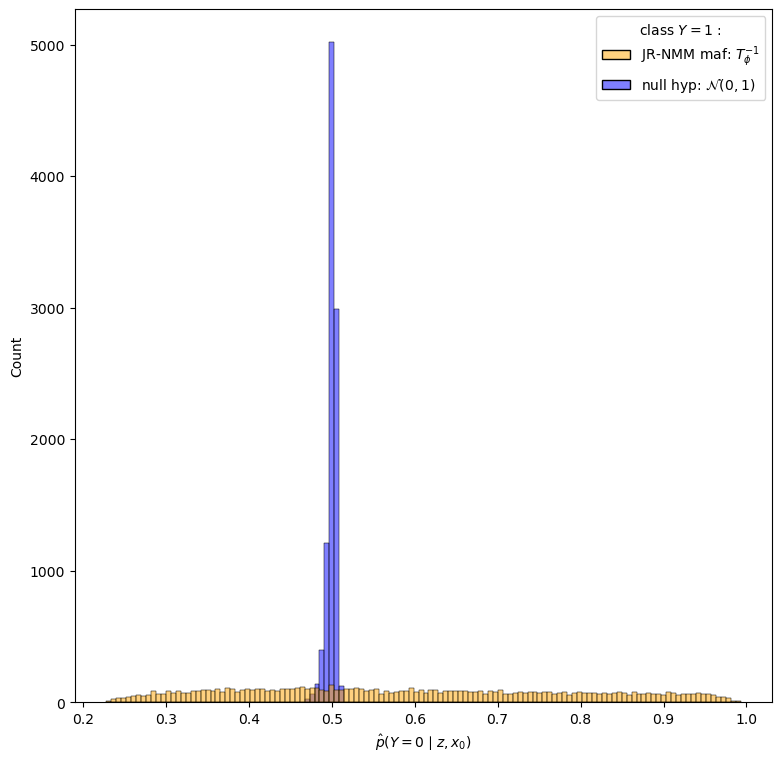

In [22]:
# plot predicted probas for x_0 no 0
probas_z = np.concatenate(
    [
        np.mean(probas[1], axis=0),
        np.mean(probas_null[1], axis=0),
    ]
)
# grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'JR-NMM maf: $T^{-1}_{\phi}$']*10000+[r'null hyp: $\mathcal{N}(0,1)$']*10000

df = pd.DataFrame({r'class $Y=1$ :': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas_z})

import seaborn as sns
sns.histplot(
        data=df, x=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'class $Y=1$ :',  palette=['orange', 'blue']
    )
plt.show()

In [73]:
df = pd.DataFrame({'z_1':z_values[:,0],'z_2':z_values[:,1], 'z_3':z_values[:,2], 'probas': np.array(probas[1]).mean(axis=0)})
# df[df['probas']>0.55]
df['intensity'] = ['uncertain']*len(df)
df.loc[df['probas']>0.55, 'intensity'] = 'high'
df.loc[df['probas']<0.45, 'intensity'] = 'low'

In [74]:
import plotly.express as px

fig = px.scatter_3d(df, x='z_1', y='z_2', z='z_3',
              color='intensity')
fig.show()

In [75]:
high_probas = z_values[np.where(df['intensity'] == 'high')[0]]
low_probas = z_values[np.where(df['intensity'] == 'low')[0]]
uncertain = z_values[np.where(df['intensity'] == 'uncertain')[0]]

fwd_flow = posterior._flow._transform.inverse(torch.FloatTensor(z_values), context=x_obs_list[1][None,:,0])[0].detach().numpy()
fwd_flow_hp = posterior._flow._transform.inverse(torch.FloatTensor(high_probas), context=x_obs_list[1][None,:,0])[0].detach().numpy()
fwd_flow_lp = posterior._flow._transform.inverse(torch.FloatTensor(low_probas), context=x_obs_list[1][None,:,0])[0].detach().numpy()
fwd_flow_u = posterior._flow._transform.inverse(torch.FloatTensor(uncertain), context=x_obs_list[1][None,:,0])[0].detach().numpy()

df['C'] = fwd_flow[:,0]
df['mu'] = fwd_flow[:,1]
df['sigma'] = fwd_flow[:,2]

fig = px.scatter_3d(df, x='C', y='mu', z='sigma',
              color='intensity')
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[10,250],),
                     yaxis = dict(nticks=4, range=[50,500],),
                     zaxis = dict(nticks=4, range=[100,5000],),),)
fig.show()

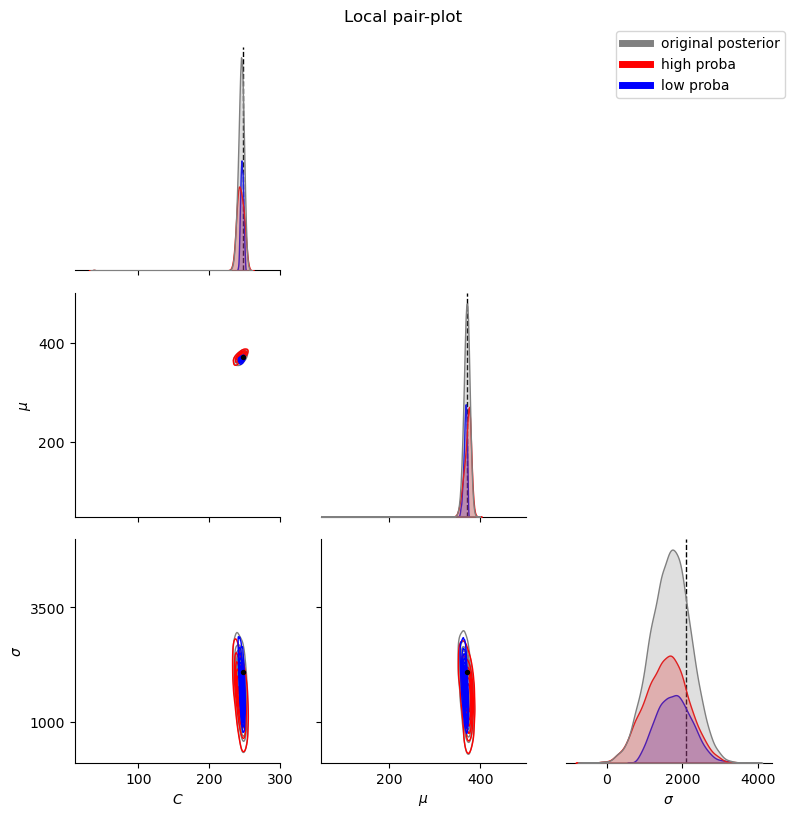

In [76]:
plt.rcParams["figure.figsize"] = (9, 9)

sample_list = [fwd_flow, fwd_flow_hp, fwd_flow_lp]
modes = ["original posterior","high proba","low proba"]
color_dict = dict(zip(modes, ['grey','red', 'blue']))
gt = theta_true_list[1]

dfs = []
for samples, mode in zip(sample_list,modes):
    df = pd.DataFrame(
        samples, columns=[r"$C$", r"$\mu$", r"$\sigma$"]
    )
    df["mode"] = mode
    dfs.append(df)

joint_df = pd.concat(dfs, ignore_index=True)

g = sns.PairGrid(
    joint_df, hue="mode", palette=color_dict, diag_sharey=False, corner=True
)
g.fig.set_size_inches(8, 8)

g.map_lower(sns.kdeplot, linewidths=1)
g.map_diag(sns.kdeplot, shade=True, linewidths=1)

g.axes[1][0].set_xlim(10.0, 300.0)  # C
g.axes[1][0].set_ylim(50.0, 500.0)  # mu
g.axes[1][0].set_yticks([200, 400])

g.axes[2][0].set_xlim(10.0, 300.0)  # C
g.axes[2][0].set_ylim(100.0, 5000.0)  # sigma
g.axes[2][0].set_yticks([1000, 3500])

g.axes[2][1].set_xlim(50.0, 500.0)  # mu
g.axes[2][1].set_ylim(100.0, 5000.0)  # sigma



C, mu, sigma = gt
# plot points
g.axes[1][0].scatter(C, mu, color="black", zorder=2, s=8)
g.axes[2][0].scatter(C, sigma, color="black", zorder=2, s=8)
g.axes[2][1].scatter(mu, sigma, color="black", zorder=2, s=8)
# plot dirac
g.axes[0][0].axvline(x=C, ls="--", c="black", linewidth=1)
g.axes[1][1].axvline(x=mu, ls="--", c="black", linewidth=1)
g.axes[2][2].axvline(x=sigma, ls="--", c="black", linewidth=1)

handles=[
        plt.Line2D([], [], color=color_dict[mode], linewidth=5, label=mode) for mode in modes
    ]

plt.legend(
    handles=handles,
    # title=title,
    bbox_to_anchor=(1.1, 3.3),
    # loc="upper right",
)
g.fig.suptitle("Local pair-plot", y=1.02)
plt.show()


#### Interpretability for x_0 number 2

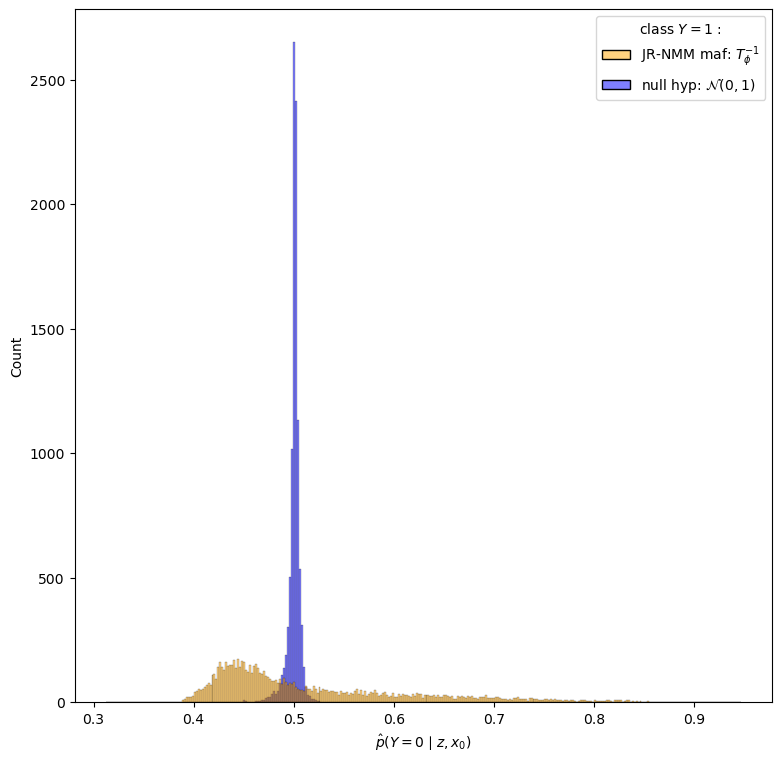

In [25]:
# plot predicted probas for x_0 no 0
probas_z = np.concatenate(
    [
        np.mean(probas[2], axis=0),
        np.mean(probas_null[2], axis=0),
    ]
)
# grids = np.concatenate([grid.reshape(-1,1)]*30)
names = [r'JR-NMM maf: $T^{-1}_{\phi}$']*10000+[r'null hyp: $\mathcal{N}(0,1)$']*10000

df = pd.DataFrame({r'class $Y=1$ :': names, r'$\hat{p}(Y=0 \mid z,x_0)$': probas_z})

import seaborn as sns
sns.histplot(
        data=df, x=r"$\hat{p}(Y=0 \mid z,x_0)$",
        hue=r'class $Y=1$ :',  palette=['orange', 'blue']
    )
plt.show()

In [77]:
df = pd.DataFrame({'z_1':z_values[:,0],'z_2':z_values[:,1], 'z_3':z_values[:,2], 'probas': np.array(probas[2]).mean(axis=0)})
# df[df['probas']>0.55]
df['intensity'] = ['uncertain']*len(df)
df.loc[df['probas']>0.55, 'intensity'] = 'high'
df.loc[df['probas']<0.45, 'intensity'] = 'low'

In [78]:
import plotly.express as px

fig = px.scatter_3d(df, x='z_1', y='z_2', z='z_3',
              color='intensity')
fig.show()

In [79]:
high_probas = z_values[np.where(df['intensity'] == 'high')[0]]
low_probas = z_values[np.where(df['intensity'] == 'low')[0]]
uncertain = z_values[np.where(df['intensity'] == 'uncertain')[0]]

fwd_flow = posterior._flow._transform.inverse(torch.FloatTensor(z_values), context=x_obs_list[2][None,:,0])[0].detach().numpy()
fwd_flow_hp = posterior._flow._transform.inverse(torch.FloatTensor(high_probas), context=x_obs_list[2][None,:,0])[0].detach().numpy()
fwd_flow_lp = posterior._flow._transform.inverse(torch.FloatTensor(low_probas), context=x_obs_list[2][None,:,0])[0].detach().numpy()
fwd_flow_u = posterior._flow._transform.inverse(torch.FloatTensor(uncertain), context=x_obs_list[2][None,:,0])[0].detach().numpy()

df['C'] = fwd_flow[:,0]
df['mu'] = fwd_flow[:,1]
df['sigma'] = fwd_flow[:,2]

fig = px.scatter_3d(df, x='C', y='mu', z='sigma',
              color='intensity')
fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4, range=[10,250],),
                     yaxis = dict(nticks=4, range=[50,500],),
                     zaxis = dict(nticks=4, range=[100,5000],),),)
fig.show()

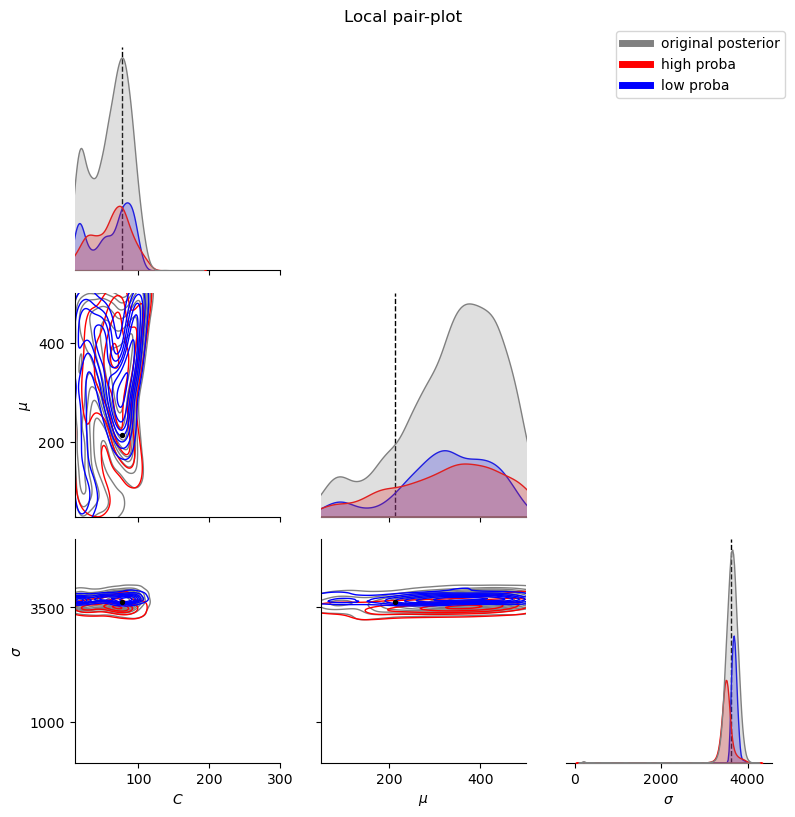

In [80]:
plt.rcParams["figure.figsize"] = (9, 9)

sample_list = [fwd_flow, fwd_flow_hp, fwd_flow_lp]
modes = ["original posterior","high proba","low proba"]
color_dict = dict(zip(modes, ['grey','red', 'blue']))
gt = theta_true_list[2]

dfs = []
for samples, mode in zip(sample_list,modes):
    df = pd.DataFrame(
        samples, columns=[r"$C$", r"$\mu$", r"$\sigma$"]
    )
    df["mode"] = mode
    dfs.append(df)

joint_df = pd.concat(dfs, ignore_index=True)

g = sns.PairGrid(
    joint_df, hue="mode", palette=color_dict, diag_sharey=False, corner=True
)
g.fig.set_size_inches(8, 8)

g.map_lower(sns.kdeplot, linewidths=1)
g.map_diag(sns.kdeplot, shade=True, linewidths=1)

g.axes[1][0].set_xlim(10.0, 300.0)  # C
g.axes[1][0].set_ylim(50.0, 500.0)  # mu
g.axes[1][0].set_yticks([200, 400])

g.axes[2][0].set_xlim(10.0, 300.0)  # C
g.axes[2][0].set_ylim(100.0, 5000.0)  # sigma
g.axes[2][0].set_yticks([1000, 3500])

g.axes[2][1].set_xlim(50.0, 500.0)  # mu
g.axes[2][1].set_ylim(100.0, 5000.0)  # sigma



C, mu, sigma = gt
# plot points
g.axes[1][0].scatter(C, mu, color="black", zorder=2, s=8)
g.axes[2][0].scatter(C, sigma, color="black", zorder=2, s=8)
g.axes[2][1].scatter(mu, sigma, color="black", zorder=2, s=8)
# plot dirac
g.axes[0][0].axvline(x=C, ls="--", c="black", linewidth=1)
g.axes[1][1].axvline(x=mu, ls="--", c="black", linewidth=1)
g.axes[2][2].axvline(x=sigma, ls="--", c="black", linewidth=1)

handles=[
        plt.Line2D([], [], color=color_dict[mode], linewidth=5, label=mode) for mode in modes
    ]

plt.legend(
    handles=handles,
    # title=title,
    bbox_to_anchor=(1.1, 3.3),
    # loc="upper right",
)
g.fig.suptitle("Local pair-plot", y=1.02)
plt.show()
